In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns



In [2]:
H, W = 224, 224
BATCH_SIZE = 64

In [3]:
image_paths = []
image_labels = []
glioma_count = menin_count = tumor_count = 0

for dirname, _, filenames in os.walk('/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        image_paths.append(path)
        if 'brain_glioma' in filename:
            image_labels.append(0)
            glioma_count += 1
        elif 'brain_menin' in filename:
            image_labels.append(1)
            menin_count += 1
        else:
            image_labels.append(2)
            tumor_count += 1

#Shuffle
combined = list(zip(image_paths, image_labels))
random.shuffle(combined)
image_paths, image_labels = zip(*combined)
image_paths = list(image_paths)
image_labels = list(image_labels)

print(image_paths[:5], '\n')
print(image_labels[:5], '\n')

print("Image count:", len(image_paths))
print("Brain glioma count:", glioma_count)
print("Brain menin count:", menin_count)
print("Brain tumor count:", tumor_count)

print("Image size:", Image.open(image_paths[0]).size)
print("Image mode:", Image.open(image_paths[0]).mode)

['/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_tumor/brain_tumor_0661.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_glioma/brain_glioma_3300.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_tumor/brain_tumor_2577.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_tumor/brain_tumor_1190.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_menin/brain_menin_3170.jpg'] 

[2, 0, 2, 2, 1] 

Image count: 15000
Brain glioma count: 5000
Brain menin count: 5000
Brain tumor count: 5000
Image size: (512, 512)
Image mode: RGB


In [4]:
#train, val, test = 80%, 10%, 10%
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, image_labels, test_size=0.2, stratify=image_labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels)

print('Train size:', len(train_paths))
print('val size:', len(val_paths))
print('Test size:', len(test_paths))

Train size: 12000
val size: 1500
Test size: 1500


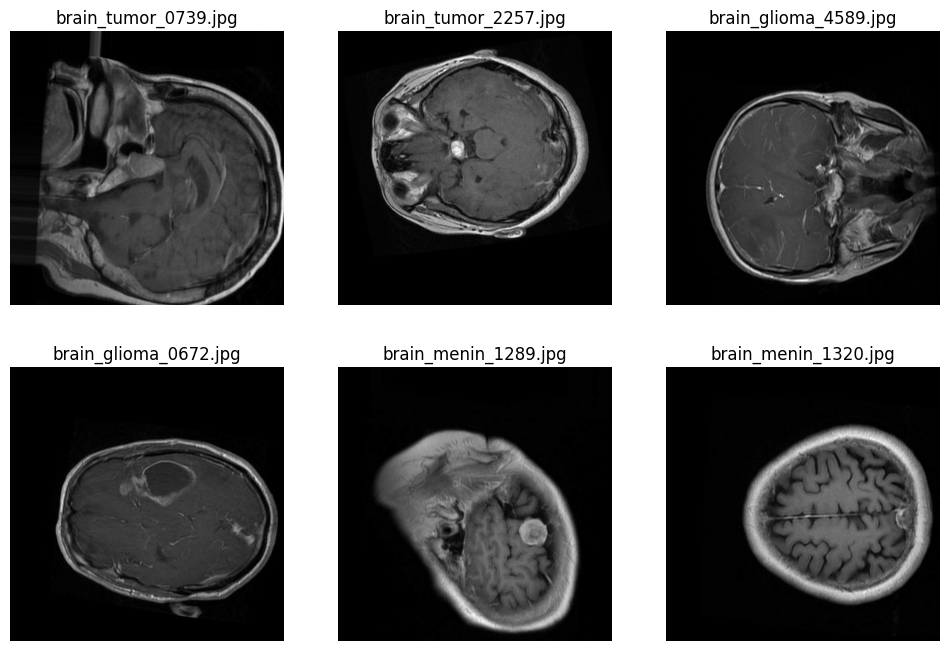

In [5]:
sample_images = random.sample(train_paths, 6)
plt.figure(figsize=(12, 8))

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=12)
    plt.axis('off')

plt.show()

In [6]:
# Calculate Mean and Standard Deviation of the training set
transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor()
])

mean = 0.
std = 0.
n = 0

for path in tqdm(train_paths):
    img = Image.open(path).convert('RGB')
    img = transform(img)  # shape: [3, H, W]
    mean += img.mean(dim=[1,2])
    std += img.std(dim=[1,2])
    n += 1

mean /= n
std /= n

print("Mean:", mean)
print("Std:", std)

100%|██████████| 12000/12000 [01:56<00:00, 102.61it/s]

Mean: tensor([0.1540, 0.1540, 0.1540])
Std: tensor([0.1643, 0.1643, 0.1643])


In [7]:
train_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

val_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

test_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

In [8]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transform=None):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.image_labels[idx]

        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)

        return img, label

train_dataset = ImageDataset(train_paths, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 

val_dataset = ImageDataset(val_paths, val_labels, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True) 

test_dataset = ImageDataset(test_paths, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True) 

In [9]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

In [10]:

EPOCH = 25                 

best_model_path = "best_oral_cancer_model.pth"

# 設置 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


print("Loading ResNet50 model...")
model = models.resnet50(pretrained=True)

# 凍結所有層
for param in model.parameters():
    param.requires_grad = False

# 最後的分類層
num_features = model.fc.in_features 
model.fc = nn.Linear(num_features, 3) 

model = model.to(device)

# --- Training ---
print("\n--- Training  ---")

criterion = nn.CrossEntropyLoss()

# 優化器 
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0

for epoch in range(EPOCH):
    model.train() 
    train_loss = 0.0
    train_corrects = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCH} [Phase 1 Train]")
    
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        train_pbar.set_postfix({'loss': loss.item()})

    epoch_train_loss = train_loss / len(train_dataset)
    epoch_train_acc = train_corrects.double() / len(train_dataset)

    model.eval() 
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCH} [Phase 1 Val]")
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_pbar.set_postfix({'loss': loss.item()})

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_corrects.double() / len(val_dataset)


    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc.item())
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc.item())

    print(f"Phase 1 Epoch {epoch+1}/{EPOCH} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
    
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved to {best_model_path} with Val Acc: {best_val_acc:.4f}")
        
print("finished.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Loading ResNet50 model...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 219MB/s]



--- Training  ---


Epoch 1/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s, loss=0.415]


Phase 1 Epoch 1/25 | Train Loss: 0.4546 Acc: 0.8326 | Val Loss: 0.3320 Acc: 0.8960
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8960


Epoch 2/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s, loss=0.38] 


Phase 1 Epoch 2/25 | Train Loss: 0.2989 Acc: 0.8918 | Val Loss: 0.2763 Acc: 0.9033
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.9033


Epoch 3/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s, loss=0.137]


Phase 1 Epoch 3/25 | Train Loss: 0.2714 Acc: 0.9026 | Val Loss: 0.2572 Acc: 0.9087
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.9087


Epoch 4/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s, loss=0.373]


Phase 1 Epoch 4/25 | Train Loss: 0.2595 Acc: 0.9053 | Val Loss: 0.2650 Acc: 0.8953


Epoch 5/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  2.00it/s, loss=0.187]


Phase 1 Epoch 5/25 | Train Loss: 0.2573 Acc: 0.9048 | Val Loss: 0.2192 Acc: 0.9200
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.9200


Epoch 6/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s, loss=0.365]


Phase 1 Epoch 6/25 | Train Loss: 0.2349 Acc: 0.9102 | Val Loss: 0.2561 Acc: 0.9073


Epoch 7/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s, loss=0.163]


Phase 1 Epoch 7/25 | Train Loss: 0.2372 Acc: 0.9105 | Val Loss: 0.2266 Acc: 0.9213
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.9213


Epoch 8/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:13<00:00,  1.79it/s, loss=0.0922]


Phase 1 Epoch 8/25 | Train Loss: 0.2352 Acc: 0.9103 | Val Loss: 0.2109 Acc: 0.9200


Epoch 9/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.91it/s, loss=0.177]


Phase 1 Epoch 9/25 | Train Loss: 0.2329 Acc: 0.9125 | Val Loss: 0.2096 Acc: 0.9227
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.9227


Epoch 10/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.96it/s, loss=0.145]


Phase 1 Epoch 10/25 | Train Loss: 0.2137 Acc: 0.9186 | Val Loss: 0.2044 Acc: 0.9200


Epoch 11/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.94it/s, loss=0.122]


Phase 1 Epoch 11/25 | Train Loss: 0.2135 Acc: 0.9202 | Val Loss: 0.1972 Acc: 0.9260
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.9260


Epoch 12/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  2.00it/s, loss=0.185]


Phase 1 Epoch 12/25 | Train Loss: 0.2194 Acc: 0.9183 | Val Loss: 0.1878 Acc: 0.9327
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.9327


Epoch 13/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s, loss=0.152] 


Phase 1 Epoch 13/25 | Train Loss: 0.2200 Acc: 0.9176 | Val Loss: 0.1868 Acc: 0.9280


Epoch 14/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s, loss=0.091]


Phase 1 Epoch 14/25 | Train Loss: 0.2139 Acc: 0.9198 | Val Loss: 0.1849 Acc: 0.9320


Epoch 15/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s, loss=0.0866]


Phase 1 Epoch 15/25 | Train Loss: 0.2055 Acc: 0.9229 | Val Loss: 0.2028 Acc: 0.9300


Epoch 16/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  2.00it/s, loss=0.228] 


Phase 1 Epoch 16/25 | Train Loss: 0.2039 Acc: 0.9239 | Val Loss: 0.1980 Acc: 0.9280


Epoch 17/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s, loss=0.161] 


Phase 1 Epoch 17/25 | Train Loss: 0.1920 Acc: 0.9282 | Val Loss: 0.1825 Acc: 0.9333
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.9333


Epoch 18/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.92it/s, loss=0.166]


Phase 1 Epoch 18/25 | Train Loss: 0.2062 Acc: 0.9224 | Val Loss: 0.1923 Acc: 0.9293


Epoch 19/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.94it/s, loss=0.128]


Phase 1 Epoch 19/25 | Train Loss: 0.1959 Acc: 0.9281 | Val Loss: 0.1902 Acc: 0.9287


Epoch 20/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.94it/s, loss=0.205] 


Phase 1 Epoch 20/25 | Train Loss: 0.1915 Acc: 0.9303 | Val Loss: 0.1763 Acc: 0.9373
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.9373


Epoch 21/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.93it/s, loss=0.216] 


Phase 1 Epoch 21/25 | Train Loss: 0.1907 Acc: 0.9283 | Val Loss: 0.1800 Acc: 0.9347


Epoch 22/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.95it/s, loss=0.192] 


Phase 1 Epoch 22/25 | Train Loss: 0.1884 Acc: 0.9295 | Val Loss: 0.1764 Acc: 0.9327


Epoch 23/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.94it/s, loss=0.333] 


Phase 1 Epoch 23/25 | Train Loss: 0.2069 Acc: 0.9226 | Val Loss: 0.1735 Acc: 0.9353


Epoch 24/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.93it/s, loss=0.128]


Phase 1 Epoch 24/25 | Train Loss: 0.1978 Acc: 0.9262 | Val Loss: 0.1740 Acc: 0.9347


Epoch 25/25 [Phase 1 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.97it/s, loss=0.192] 

Phase 1 Epoch 25/25 | Train Loss: 0.1896 Acc: 0.9295 | Val Loss: 0.1649 Acc: 0.9367
finished.


In [11]:
# 模型微調 
print("\n--- Fine-Tuning ---")

NUM_FINETUNE_EPOCHS = 20   

model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from Phase 1 with Val Acc: {best_val_acc:.4f}")


for param in model.parameters():
    param.requires_grad = True


optimizer = optim.Adam(model.parameters(), lr=1e-5) 

best_finetune_acc = best_val_acc 

for epoch in range(NUM_FINETUNE_EPOCHS):
    model.train()
    train_loss = 0.0
    train_corrects = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} [Phase 2 Train]")
    
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        train_pbar.set_postfix({'loss': loss.item()})

    epoch_train_loss = train_loss / len(train_dataset)
    epoch_train_acc = train_corrects.double() / len(train_dataset)

    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} [Phase 2 Val]")
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_pbar.set_postfix({'loss': loss.item()})

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_corrects.double() / len(val_dataset)

    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc.item())
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc.item())

    print(f"Phase 2 Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
    
    if epoch_val_acc > best_finetune_acc:
        best_finetune_acc = epoch_val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New BEST model saved (Fine-Tuning) to {best_model_path} with Val Acc: {best_finetune_acc:.4f}")

print(" Fine-tuning finished.")




--- Fine-Tuning ---
Loaded best model from Phase 1 with Val Acc: 0.9373


Epoch 1/20 [Phase 2 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.90it/s, loss=0.0855]


Phase 2 Epoch 1/20 | Train Loss: 0.1224 Acc: 0.9544 | Val Loss: 0.0658 Acc: 0.9787
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9787


Epoch 2/20 [Phase 2 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.91it/s, loss=0.0238] 


Phase 2 Epoch 2/20 | Train Loss: 0.0581 Acc: 0.9792 | Val Loss: 0.0429 Acc: 0.9833
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9833


Epoch 3/20 [Phase 2 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.88it/s, loss=0.012]  


Phase 2 Epoch 3/20 | Train Loss: 0.0349 Acc: 0.9878 | Val Loss: 0.0237 Acc: 0.9913
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9913


Epoch 4/20 [Phase 2 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.89it/s, loss=0.00836]


Phase 2 Epoch 4/20 | Train Loss: 0.0244 Acc: 0.9931 | Val Loss: 0.0169 Acc: 0.9953
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9953


Epoch 5/20 [Phase 2 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.87it/s, loss=0.00382]


Phase 2 Epoch 5/20 | Train Loss: 0.0177 Acc: 0.9938 | Val Loss: 0.0136 Acc: 0.9947


Epoch 6/20 [Phase 2 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.86it/s, loss=0.015]   


Phase 2 Epoch 6/20 | Train Loss: 0.0116 Acc: 0.9965 | Val Loss: 0.0085 Acc: 0.9973
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9973


Epoch 7/20 [Phase 2 Val]: 100%|██████████| 24/24 [00:21<00:00,  1.12it/s, loss=0.00194] 


Phase 2 Epoch 7/20 | Train Loss: 0.0090 Acc: 0.9973 | Val Loss: 0.0082 Acc: 0.9980
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9980


Epoch 8/20 [Phase 2 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.87it/s, loss=0.000628]


Phase 2 Epoch 8/20 | Train Loss: 0.0069 Acc: 0.9982 | Val Loss: 0.0068 Acc: 0.9967


Epoch 9/20 [Phase 2 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.87it/s, loss=0.000995]


Phase 2 Epoch 9/20 | Train Loss: 0.0082 Acc: 0.9975 | Val Loss: 0.0103 Acc: 0.9967


Epoch 10/20 [Phase 2 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.85it/s, loss=4.23e-5] 


Phase 2 Epoch 10/20 | Train Loss: 0.0060 Acc: 0.9977 | Val Loss: 0.0052 Acc: 0.9980


Epoch 11/20 [Phase 2 Val]: 100%|██████████| 24/24 [00:13<00:00,  1.83it/s, loss=0.00891] 


Phase 2 Epoch 11/20 | Train Loss: 0.0044 Acc: 0.9989 | Val Loss: 0.0034 Acc: 0.9993
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9993


Epoch 12/20 [Phase 2 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.88it/s, loss=0.000113]


Phase 2 Epoch 12/20 | Train Loss: 0.0045 Acc: 0.9986 | Val Loss: 0.0042 Acc: 0.9987


Epoch 13/20 [Phase 2 Val]: 100%|██████████| 24/24 [00:13<00:00,  1.83it/s, loss=4.04e-5] 


Phase 2 Epoch 13/20 | Train Loss: 0.0043 Acc: 0.9987 | Val Loss: 0.0035 Acc: 0.9980


Epoch 14/20 [Phase 2 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.90it/s, loss=0.00117] 


Phase 2 Epoch 14/20 | Train Loss: 0.0059 Acc: 0.9982 | Val Loss: 0.0044 Acc: 0.9980


Epoch 15/20 [Phase 2 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.90it/s, loss=0.00637] 


Phase 2 Epoch 15/20 | Train Loss: 0.0038 Acc: 0.9991 | Val Loss: 0.0029 Acc: 0.9993


Epoch 16/20 [Phase 2 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.86it/s, loss=0.000134]


Phase 2 Epoch 16/20 | Train Loss: 0.0024 Acc: 0.9996 | Val Loss: 0.0018 Acc: 1.0000
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 1.0000


Epoch 17/20 [Phase 2 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.88it/s, loss=0.000113]


Phase 2 Epoch 17/20 | Train Loss: 0.0026 Acc: 0.9993 | Val Loss: 0.0036 Acc: 0.9987


Epoch 18/20 [Phase 2 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.86it/s, loss=8.05e-6] 


Phase 2 Epoch 18/20 | Train Loss: 0.0040 Acc: 0.9987 | Val Loss: 0.0051 Acc: 0.9980


Epoch 19/20 [Phase 2 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.88it/s, loss=7.01e-5] 


Phase 2 Epoch 19/20 | Train Loss: 0.0030 Acc: 0.9989 | Val Loss: 0.0021 Acc: 0.9993


Epoch 20/20 [Phase 2 Val]: 100%|██████████| 24/24 [00:12<00:00,  1.86it/s, loss=9.28e-6] 

Phase 2 Epoch 20/20 | Train Loss: 0.0017 Acc: 0.9994 | Val Loss: 0.0008 Acc: 1.0000
 Fine-tuning finished.


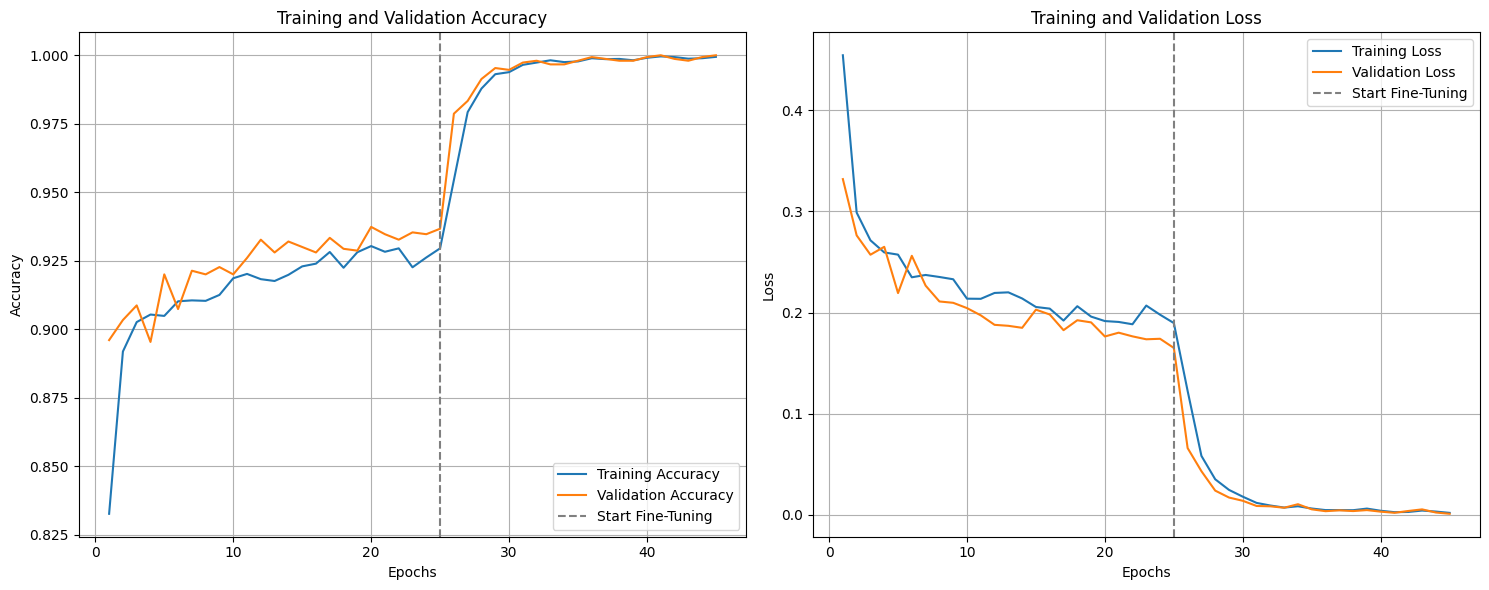

In [12]:
# ---  Learning Curve ---
def plot_learning_curves(history, phase1_epochs):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    
    plt.axvline(x=phase1_epochs, color='gray', linestyle='--', label='Start Fine-Tuning')
    
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    

    plt.axvline(x=phase1_epochs, color='gray', linestyle='--', label='Start Fine-Tuning')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_learning_curves(history, phase1_epochs=EPOCH)

In [13]:
from torch.utils.data import ConcatDataset, DataLoader

full_train_dataset = ConcatDataset([train_dataset, val_dataset])

full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


model.load_state_dict(torch.load(best_model_path))

history_phase3 = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [], 
    'val_acc': []
}

REFINE_EPOCHS = 20 
optimizer = optim.Adam(model.parameters(), lr=1e-5) 
criterion = nn.CrossEntropyLoss()



for epoch in range(REFINE_EPOCHS):
    model.train()
    train_loss = 0.0
    train_corrects = 0
    
    pbar = tqdm(full_train_loader, desc=f"Epoch {epoch+1}/{REFINE_EPOCHS} [Train]")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        
        pbar.set_postfix({'loss': loss.item()})
        
    epoch_train_loss = train_loss / len(full_train_dataset)
    epoch_train_acc = (train_corrects.double() / len(full_train_dataset)).item()


    model.eval()
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            
    epoch_val_loss = val_loss / len(test_dataset)
    epoch_val_acc = (val_corrects.double() / len(test_dataset)).item()


    history_phase3['train_loss'].append(epoch_train_loss)
    history_phase3['train_acc'].append(epoch_train_acc)
    history_phase3['val_loss'].append(epoch_val_loss)
    history_phase3['val_acc'].append(epoch_val_acc)

    print(f"   Train Acc: {epoch_train_acc:.4f} | Test Acc: {epoch_val_acc:.4f}")


final_model_path = "final_refined_model.pth"
torch.save(model.state_dict(), final_model_path)

Epoch 1/20 [Train]: 100%|██████████| 211/211 [02:17<00:00,  1.53it/s, loss=0.0111]  


   Train Acc: 0.9982 | Test Acc: 0.9993


Epoch 2/20 [Train]: 100%|██████████| 211/211 [02:18<00:00,  1.53it/s, loss=0.000688]


   Train Acc: 0.9993 | Test Acc: 0.9987


Epoch 3/20 [Train]: 100%|██████████| 211/211 [02:17<00:00,  1.53it/s, loss=0.000972]


   Train Acc: 0.9994 | Test Acc: 0.9987


Epoch 4/20 [Train]: 100%|██████████| 211/211 [02:17<00:00,  1.53it/s, loss=1.9e-5]  


   Train Acc: 0.9993 | Test Acc: 0.9993


Epoch 5/20 [Train]: 100%|██████████| 211/211 [02:17<00:00,  1.53it/s, loss=0.00171] 


   Train Acc: 0.9989 | Test Acc: 0.9980


Epoch 6/20 [Train]: 100%|██████████| 211/211 [02:17<00:00,  1.53it/s, loss=0.00618] 


   Train Acc: 0.9990 | Test Acc: 1.0000


Epoch 7/20 [Train]: 100%|██████████| 211/211 [02:17<00:00,  1.53it/s, loss=0.00192] 


   Train Acc: 0.9991 | Test Acc: 1.0000


Epoch 8/20 [Train]: 100%|██████████| 211/211 [02:18<00:00,  1.53it/s, loss=0.000617]


   Train Acc: 0.9993 | Test Acc: 0.9993


Epoch 9/20 [Train]: 100%|██████████| 211/211 [02:34<00:00,  1.37it/s, loss=2.79e-5] 


   Train Acc: 0.9994 | Test Acc: 0.9987


Epoch 10/20 [Train]: 100%|██████████| 211/211 [02:17<00:00,  1.53it/s, loss=0.00227] 


   Train Acc: 0.9994 | Test Acc: 0.9993


Epoch 11/20 [Train]: 100%|██████████| 211/211 [02:17<00:00,  1.53it/s, loss=4.3e-6]  


   Train Acc: 0.9993 | Test Acc: 0.9993


Epoch 12/20 [Train]: 100%|██████████| 211/211 [02:17<00:00,  1.53it/s, loss=0.0322]  


   Train Acc: 0.9988 | Test Acc: 1.0000


Epoch 13/20 [Train]: 100%|██████████| 211/211 [02:17<00:00,  1.53it/s, loss=0.000228]


   Train Acc: 0.9994 | Test Acc: 0.9980


Epoch 14/20 [Train]: 100%|██████████| 211/211 [02:17<00:00,  1.53it/s, loss=2.54e-5] 


   Train Acc: 0.9996 | Test Acc: 0.9993


Epoch 15/20 [Train]: 100%|██████████| 211/211 [02:17<00:00,  1.53it/s, loss=0.000318]


   Train Acc: 0.9997 | Test Acc: 1.0000


Epoch 16/20 [Train]: 100%|██████████| 211/211 [02:17<00:00,  1.53it/s, loss=0.000255]


   Train Acc: 0.9996 | Test Acc: 0.9980


Epoch 17/20 [Train]: 100%|██████████| 211/211 [02:17<00:00,  1.53it/s, loss=6.8e-5]  


   Train Acc: 0.9996 | Test Acc: 1.0000


Epoch 18/20 [Train]: 100%|██████████| 211/211 [02:17<00:00,  1.53it/s, loss=4.69e-6] 


   Train Acc: 0.9999 | Test Acc: 0.9993


Epoch 19/20 [Train]: 100%|██████████| 211/211 [02:17<00:00,  1.53it/s, loss=9.14e-6] 


   Train Acc: 0.9996 | Test Acc: 1.0000


Epoch 20/20 [Train]: 100%|██████████| 211/211 [02:17<00:00,  1.53it/s, loss=2.8e-5]  


   Train Acc: 0.9996 | Test Acc: 0.9987


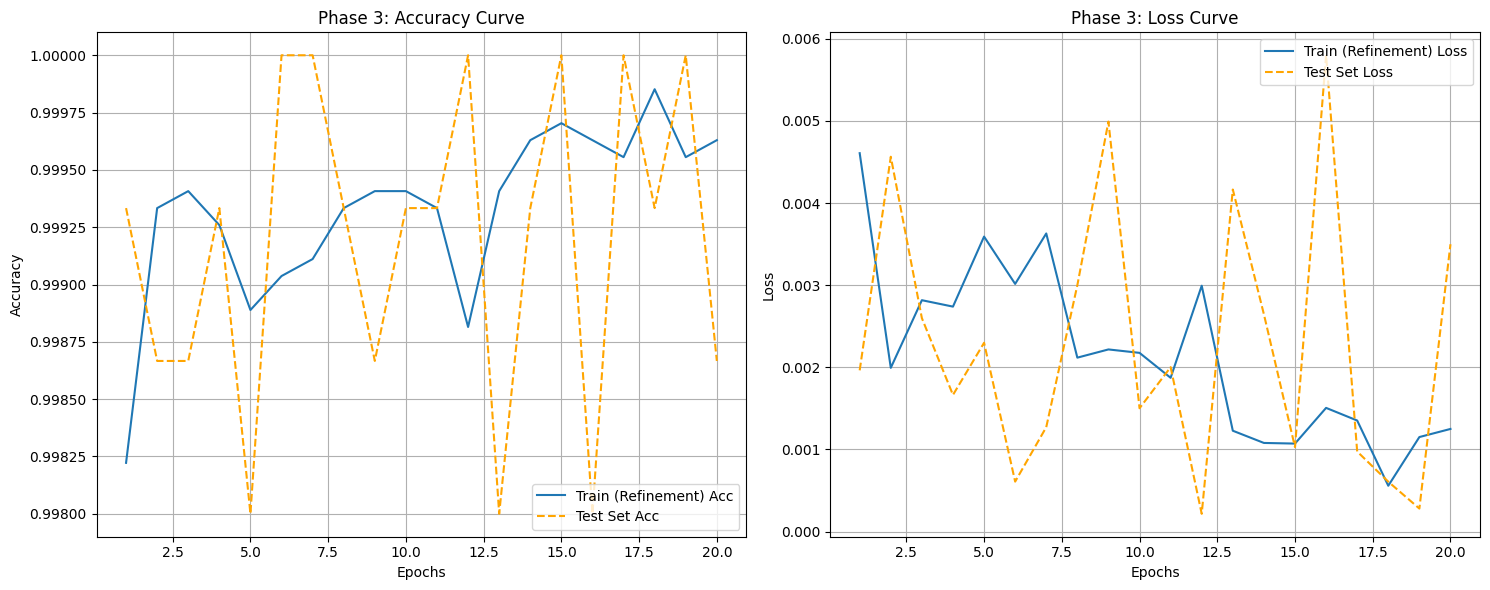

In [14]:
def plot_phase3_curves(history):
    acc = history['train_acc']
    val_acc = history['val_acc'] 
    loss = history['train_loss']
    val_loss = history['val_loss'] 
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 6))

    # Accuracy Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train (Refinement) Acc')
    plt.plot(epochs_range, val_acc, label='Test Set Acc', color='orange', linestyle='--')
    plt.title('Phase 3: Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Loss Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train (Refinement) Loss')
    plt.plot(epochs_range, val_loss, label='Test Set Loss', color='orange', linestyle='--')
    plt.title('Phase 3: Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 執行畫圖
plot_phase3_curves(history_phase3)


--- Final Testing & Metrics Calculation ---


Testing: 100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


 Final Results (Brain Cancer)
Accuracy  : 0.9987
Precision : 0.9987
Recall    : 0.9987
F1 Score  : 0.9987
------------------------------

 Report 
              precision    recall  f1-score   support

      Glioma       1.00      1.00      1.00       500
  Meningioma       1.00      1.00      1.00       500
       Tumor       1.00      1.00      1.00       500

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



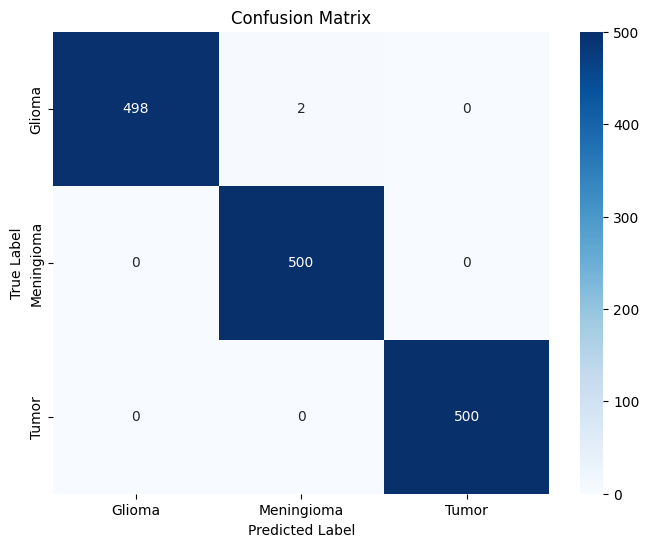

In [17]:
print("\n--- Final Testing & Metrics Calculation ---")


model.load_state_dict(torch.load(final_model_path))
model.eval()
model.to(device)

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())


accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print("\n" + "="*30)
print(f" Final Results (Brain Cancer)")
print("="*30)
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print("-" * 30)


target_names = ['Glioma', 'Meningioma', 'Tumor']
print("\n Report ")
print(classification_report(all_labels, all_preds, target_names=target_names))


cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()